# Computational Thermofluid Dynamics - Chapter 5

Technical University of Munich, Professur für Thermofluiddynamik - Pr. Polifke

Created: 04/2024 | J. Yao, N. Garcia, G. Varillon

==============================================================================================

# Linear solvers

In [14]:
import numpy as np
from scipy.sparse import dia_matrix, csr_matrix, csc_matrix, tril, identity, triu
from scipy.sparse.linalg import spsolve_triangular, spsolve
from matplotlib.pyplot import spy
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import time

### Dense code

In [15]:
class SteadyHeat2Ddense:
    def __init__(self, Lx, Ly, dimX, dimY):
        self.l = Lx #lunghezza rettangolo
        self.h = Ly
        self.dimX = dimX #quante divisioni
        self.dimY = dimY

        self.dx = Lx/dimX
        self.dy = Ly/dimY

        self.A = np.identity(self.dimX*self.dimY)
        self.set_inner()
        self.b = np.zeros([self.dimX*self.dimY])
        
    
    # build the linear system
    def set_inner(self):
        for i in range(self.dimX+1, (self.dimX*self.dimY)-self.dimX-1, self.dimX): # the start of each row of inner nodes 
            for j in range(self.dimX-2): # loops through all inner nodes in that row 
                k = i+j
                # builds the matrix like in scicomplab, so each row
                self.A[k][k] = -2 * (1/(self.dx*self.dx) + 1/(self.dy*self.dy)) # central node
                self.A[k][k-1] = 1/(self.dx*self.dx) # side nodes
                self.A[k][k+1] = 1/(self.dx*self.dx)
                self.A[k][k - self.dimX] = 1/(self.dy*self.dy) # upper lower nodes
                self.A[k][k + self.dimX] = 1/(self.dy*self.dy)

    # south
    def set_south(self, bc_type, T_d=0.0, q=0.0, alpha = 0.0, T_inf=0.0):
        if (bc_type=="d"):
            try: 
                self.b[-self.dimX:] = T_d
                for i in range(self.dimX):
                    ii = (self.dimX*self.dimY) - i - 1
                    self.A[ii][ii] = 1
            except:
                print("no T_d value for source boundary type")
        elif (bc_type=="n"):
            try:
                for i in range(self.dimX):
                    ii = (self.dimX*self.dimY)-i-1
                    self.b[ii] = q
                    self.A[ii][ii] = -4/(2*self.dimY)
                    self.A[ii][ii-self.dimX] = 3/(2*self.dimY)
                    self.A[ii][ii-(2*self.dimX)] = 1/(2*self.dimY)
            except:
                print("no q value for flux boundary type")
        elif (bc_type=="r"):
            try:
                for i in range(self.dimX):
                    ii = (self.dimX*self.dimY)-i-1
                    self.b[ii] = alpha * T_inf
                    self.A[ii][ii] = alpha + 3/(2*self.dimY)
                    self.A[ii][ii-self.dimX] = -4/(2*self.dimY)
                    self.A[ii][ii-(2*self.dimX)] = 1/(2*self.dimY)
            except:
                print("no alpha or T_inf value for conjugate boundary type")
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(bc_type))


    # north
    def set_north(self, bc_type, T_d=0.0, q=0.0, alpha = 0.0, T_inf=0.0):
        if (bc_type=="d"):
            try: 
                self.b[:self.dimX] = T_d
                for i in range(self.dimX):
                    ii = (self.dimX*self.dimY) - i - 1
                    self.A[ii][ii] = 1
            except:
                print("no T_d value for source boundary type")
        elif (bc_type=="n"):
            try:
                for i in range(self.dimX):
                    ii = i
                    self.b[ii] = q
                    self.A[ii][ii] = -4/(2*self.dimY)
                    self.A[ii][ii+self.dimX] = 3/(2*self.dimY)
                    self.A[ii][ii+(2*self.dimX)] = 1/(2*self.dimY)
            except:
                print("no q value for flux boundary type")
        elif (bc_type=="r"):
            try:
                for i in range(self.dimX):
                    ii = i
                    self.b[ii] = alpha * T_inf
                    self.A[ii][ii] = alpha + 3/(2*self.dimY)
                    self.A[ii][ii+self.dimX] = -4/(2*self.dimY)
                    self.A[ii][ii+(2*self.dimX)] = 1/(2*self.dimY)
            except:
                print("no alpha or T_inf value for conjugate boundary type")
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(bc_type))


    # west
    def set_west(self, bc_type, T_d=0.0, q=0.0, alpha = 0.0, T_inf=0.0):
        if (bc_type=="d"):
            try: 
                for i in range(self.dimY):
                    ii = i * self.dimX
                    self.b[ii] = T_d
                    self.A[ii][ii] = 1
            except:
                print("no T_d value for source boundary type")
        elif (bc_type=="n"):
            try:
                for i in range(self.dimY):
                    ii = i * self.dimX
                    self.b[ii] = q
                    self.A[ii][ii] = -4/(2*self.dimX)
                    self.A[ii][ii+1] = 3/(2*self.dimX)
                    self.A[ii][ii+2] = 1/(2*self.dimX)
            except:
                print("no q value for flux boundary type")
        elif (bc_type=="r"):
            try:
                for i in range(self.dimY):
                    ii = i * self.dimX
                    self.b[ii] = alpha * T_inf
                    self.A[ii][ii] = alpha + 3/(2*self.dimX)
                    self.A[ii][ii+1] = -4/(2*self.dimX)
                    self.A[ii][ii+2] = 1/(2*self.dimX)
            except:
                print("no alpha or T_inf value for conjugate boundary type")
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(bc_type))


# east
    def set_east(self, bc_type, T_d=0.0, q=0.0, alpha = 0.0, T_inf=0.0):
        if (bc_type=="d"):
            try: 
                for i in range(self.dimY):
                    ii = i * self.dimX + self.dimX -1
                    self.b[ii] = T_d
                    self.A[ii][ii] = 1
            except:
                print("no T_d value for source boundary type")
        elif (bc_type=="n"):
            try:
                for i in range(self.dimY):
                    ii = i * self.dimX + self.dimX -1
                    self.b[ii] = q
                    self.A[ii][ii] = -4/(2*self.dimX)
                    self.A[ii][ii-1] = 3/(2*self.dimX)
                    self.A[ii][ii-2] = 1/(2*self.dimX)
            except:
                print("no q value for flux boundary type")
        elif (bc_type=="r"):
            try:
                for i in range(self.dimY):
                    ii = i * self.dimX + self.dimX -1
                    self.b[ii] = alpha * T_inf
                    self.A[ii][ii] = alpha + 3/(2*self.dimX)
                    self.A[ii][ii-1] = -4/(2*self.dimX)
                    self.A[ii][ii-2] = 1/(2*self.dimX)
            except:
                print("no alpha or T_inf value for conjugate boundary type")
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(bc_type))
       
       

    # solve the linear system
    def solve(self):
        return np.linalg.solve(self.A, self.b)


### Sparse code

In [16]:
class SteadyHeat2Dsparse:
    def __init__(self, Lx, Ly, dimX, dimY):
        self.l = Lx #lunghezza rettangolo
        self.h = Ly
        self.dimX = dimX #quante divisioni
        self.dimY = dimY

        self.dx = Lx/dimX
        self.dy = Ly/dimY

        self.A = None
        self.D_1 = None
        self.R = None

        # self.A = np.identity(self.dimX*self.dimY)
        self.diag = np.zeros([9, self.dimX*self.dimY])
        self.data = np.zeros([9, self.dimX*self.dimY])

        self.set_inner()
        self.b = np.zeros([self.dimX*self.dimY])
        
    
    # build the linear system
    def set_inner(self):
        for i in range(self.dimX+1, (self.dimX*self.dimY)-self.dimX-1, self.dimX): # the start of each row of inner nodes 
            for j in range(self.dimX-2): # loops through all inner nodes in that row 
                k = i+j
                # builds the matrix like in scicomplab, so each row
                # self.A[k][k] = -2 * (1/(self.dx*self.dx) + 1/(self.dy*self.dy)) # central node
                self.diag[4][k] = -2 * (1/(self.dx*self.dx) + 1/(self.dy*self.dy))
                # self.A[k][k-1] = 1/(self.dx*self.dx) # side nodes
                self.diag[3][k] = 1/(self.dx*self.dx)
                # self.A[k][k+1] = 1/(self.dx*self.dx)
                self.diag[5][k] = 1/(self.dx*self.dx)
                # self.A[k][k - self.dimX] = 1/(self.dy*self.dy) # upper lower nodes
                self.diag[1][k] = 1/(self.dy*self.dy)
                # self.A[k][k + self.dimX] = 1/(self.dy*self.dy)
                self.diag[7][k] = 1/(self.dy*self.dy)

    # south
    def set_south(self, bc_type, T_d=0.0, q=0.0, alpha = 0.0, T_inf=0.0):
        if (bc_type=="d"):
            try: 
                self.b[-self.dimX:] = T_d
                for i in range(self.dimX):
                    ii = (self.dimX*self.dimY) - i - 1
                    # self.A[ii][ii] = 1
                    self.diag[4][ii] = 1
            except:
                print("no T_d value for source boundary type")
        elif (bc_type=="n"):
            try:
                for i in range(self.dimX):
                    ii = (self.dimX*self.dimY)-i-1
                    self.b[ii] = q
                    # self.A[ii][ii] = -4/(2*self.dimY)
                    self.diag[4][ii] = -4/(2*self.dimY)
                    # self.A[ii][ii-self.dimX] = 3/(2*self.dimY)
                    self.diag[1][ii] = 3/(2*self.dimY)
                    # self.A[ii][ii-(2*self.dimX)] = 1/(2*self.dimY)
                    self.diag[0][ii] = 1/(2*self.dimY)
            except:
                print("no q value for flux boundary type")
        elif (bc_type=="r"):
            try:
                for i in range(self.dimX):
                    ii = (self.dimX*self.dimY)-i-1
                    self.b[ii] = alpha * T_inf
                    # self.A[ii][ii] = alpha + 3/(2*self.dimY)
                    self.diag[4][ii] = alpha + 3/(2*self.dimX)
                    # self.A[ii][ii-self.dimX] = -4/(2*self.dimY)
                    self.diag[1][ii] = -4/(2*self.dimX)
                    # self.A[ii][ii-(2*self.dimX)] = 1/(2*self.dimY)
                    self.diag[0][ii] = 1/(2*self.dimX)
            except:
                print("no alpha or T_inf value for conjugate boundary type")
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(bc_type))


    # north
    def set_north(self, bc_type, T_d=0.0, q=0.0, alpha = 0.0, T_inf=0.0):
        if (bc_type=="d"):
            try: 
                self.b[:self.dimX] = T_d
                for i in range(self.dimX):
                    # ii = (self.dimX*self.dimY) - i - 1
                    ii = i
                    # self.A[ii][ii] = 1
                    self.diag[4][ii] = 1
            except:
                print("no T_d value for source boundary type")
        elif (bc_type=="n"):
            try:
                for i in range(self.dimX):
                    ii = i
                    self.b[ii] = q
                    # self.A[ii][ii] = -4/(2*self.dimY)
                    self.diag[4][ii] = -4/(2*self.dimX)
                    # self.A[ii][ii+self.dimX] = 3/(2*self.dimY)
                    self.diag[7][ii] = -4/(2*self.dimX)
                    # self.A[ii][ii+(2*self.dimX)] = 1/(2*self.dimY)
                    self.diag[8][ii] = -4/(2*self.dimX)
            except:
                print("no q value for flux boundary type")
        elif (bc_type=="r"):
            print("north robin")
            try:
                for i in range(self.dimX):
                    ii = i
                    self.b[ii] = alpha * T_inf
                    # self.A[ii][ii] = alpha + 3/(2*self.dimY)
                    self.diag[4][ii] = alpha + 3/(2*self.dimY)
                    # self.A[ii][ii+self.dimX] = -4/(2*self.dimY)
                    self.diag[7][ii] = -4/(2*self.dimY)
                    # self.A[ii][ii+(2*self.dimX)] = 1/(2*self.dimY)
                    self.diag[8][ii] = 1/(2*self.dimY)
            except:
                print("no alpha or T_inf value for conjugate boundary type")
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(bc_type))


    # west
    def set_west(self, bc_type, T_d=0.0, q=0.0, alpha = 0.0, T_inf=0.0):
        if (bc_type=="d"):
            try: 
                for i in range(self.dimY):
                    ii = i * self.dimX
                    self.b[ii] = T_d
                    # self.A[ii][ii] = 1
                    self.diag[4][ii] = 1
            except:
                print("no T_d value for source boundary type")
        elif (bc_type=="n"):
            try:
                for i in range(self.dimY):
                    ii = i * self.dimX
                    self.b[ii] = q
                    # self.A[ii][ii] = -4/(2*self.dimX)
                    self.diag[4][ii] = -4/(2*self.dimX)
                    # self.A[ii][ii+1] = 3/(2*self.dimX)
                    self.diag[5][ii] = 3/(2*self.dimX)
                    # self.A[ii][ii+2] = 1/(2*self.dimX)
                    self.diag[6][ii] = 1/(2*self.dimX)
            except:
                print("no q value for flux boundary type")
        elif (bc_type=="r"):
            try:
                for i in range(self.dimY):
                    ii = i * self.dimX
                    self.b[ii] = alpha * T_inf
                    # self.A[ii][ii] = alpha + 3/(2*self.dimY)
                    self.diag[4][ii] = alpha + 3/(2*self.dimY)
                    # self.A[ii][ii+1] = -4/(2*self.dimY)
                    self.diag[5][ii] = -4/(2*self.dimY)
                    # self.A[ii][ii+2] = 1/(2*self.dimY)
                    self.diag[6][ii] = 1/(2*self.dimY)
            except:
                print("no alpha or T_inf value for conjugate boundary type")
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(bc_type))


# east
    def set_east(self, bc_type, T_d=0.0, q=0.0, alpha = 0.0, T_inf=0.0):
        if (bc_type=="d"):
            try: 
                for i in range(self.dimY):
                    ii = i * self.dimX + self.dimX -1
                    self.b[ii] = T_d
                    # self.A[ii][ii] = 1
                    self.diag[4][ii] = 1
            except:
                print("no T_d value for source boundary type")
        elif (bc_type=="n"):
            try:
                for i in range(self.dimY):
                    ii = i * self.dimX + self.dimX -1
                    self.b[ii] = q
                    # self.A[ii][ii] = -4/(2*self.dimX)
                    self.diag[4][ii] = -4/(2*self.dimX)
                    # self.A[ii][ii-1] = 3/(2*self.dimX)
                    self.diag[3][ii] = 3/(2*self.dimX)
                    # self.A[ii][ii-2] = 1/(2*self.dimX)
                    self.diag[2][ii] = 1/(2*self.dimX)
            except:
                print("no q value for flux boundary type")
        elif (bc_type=="r"):
            try:
                for i in range(self.dimY):
                    ii = i * self.dimX + self.dimX -1
                    self.b[ii] = alpha * T_inf
                    # self.A[ii][ii] = alpha + 3/(2*self.dimY)
                    self.diag[4][ii] = alpha + 3/(2*self.dimY)
                    # self.A[ii][ii-1] = -4/(2*self.dimY)
                    self.diag[3][ii] = -4/(2*self.dimY)
                    # self.A[ii][ii-2] = 1/(2*self.dimY)
                    self.diag[2][ii] = 1/(2*self.dimY)
            except:
                print("no alpha or T_inf value for conjugate boundary type")
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(bc_type))
       
       

    # solve the linear system
    def solve(self):
        offsets = np.array([-2*self.dimX, -self.dimX, -2, -1, 0, 1, 2, self.dimX, 2*self.dimX])

        for i, offset in enumerate(offsets):
            if offset < 0:
                self.data[i][:offset] = self.diag[i][-offset:]
            elif offset == 0:
                self.data[i] = self.diag[i]
            elif offset > 0:
                self.data[i][offset:] = self.diag[i][:-offset]

        self.A = dia_matrix((self.data, offsets), shape=(self.dimX*self.dimY, self.dimX*self.dimY))
        self.A = csr_matrix(self.A)
        return spsolve(self.A, self.b)
    


    def solveJacobi(self, threshold=0.00001, max_iterations=5000):
        residual = 1000000
        iteration = 0

        # Ensure self.diag[4] contains the main diagonal elements of A
        self.D_1 = dia_matrix((1/self.diag[4], 0), shape=(self.dimX*self.dimY, self.dimX*self.dimY))
        self.D_1 = csr_matrix(self.D_1)

        offsets = np.array([-2*self.dimX, -self.dimX, -2, -1, 0, 1, 2, self.dimX, 2*self.dimX])
        self.data = np.zeros((len(offsets), self.dimX * self.dimY))

        for i, offset in enumerate(offsets):
            if offset < 0:
                self.data[i][:offset] = self.diag[i][-offset:]
            elif offset == 0:
                self.data[i] = np.zeros(self.dimX*self.dimY)  # or self.diag[i] if it's supposed to be the main diagonal
            elif offset > 0:
                self.data[i][offset:] = self.diag[i][:-offset]

        self.R = dia_matrix((self.data, offsets), shape=(self.dimX*self.dimY, self.dimX*self.dimY))
        self.R = csr_matrix(self.R)

        x = np.zeros(self.dimX*self.dimY)
        x_new = np.zeros(self.dimX*self.dimY)

        while ((iteration < max_iterations) and (residual > threshold)):
            T = self.D_1.dot(self.R)
            x_new = self.D_1.dot(self.b) - T.dot(x)
            residual = np.linalg.norm(x_new - x)  # Ensure correct residual calculation
            iteration += 1
            x = x_new

        return x
    
    def solveGauss(self, threshold=0.00001, max_iterations=5000):
        residual = 100
        iteration = 0

        # Ensure self.diag[4] contains the main diagonal elements of A
        self.D_1 = dia_matrix((1/self.diag[4], 0), shape=(self.dimX*self.dimY, self.dimX*self.dimY))
        self.D_1 = csr_matrix(self.D_1)

        offsets = np.array([-2*self.dimX, -self.dimX, -2, -1, 0, 1, 2, self.dimX, 2*self.dimX])
        self.data = np.zeros((len(offsets), self.dimX * self.dimY))

        for i, offset in enumerate(offsets):
            if offset < 0:
                self.data[i][:offset] = self.diag[i][-offset:]
            elif offset == 0:
                self.data[i] = self.diag[i]
            elif offset > 0:
                self.data[i][offset:] = self.diag[i][:-offset]

        self.C = dia_matrix((self.data, offsets), shape=(self.dimX*self.dimY, self.dimX*self.dimY))
        self.C = csr_matrix(self.C)
        
        
        # x(m+1) = D_1 (b - Ex(m+1) -Fx(m))
        # Preconditioner C = D + E + F
        F = triu(self.C, k = 1, format = "csr")
        E = tril(self.C, k = -1, format = "csr")

        x = np.zeros(self.dimX*self.dimY)
        x_new = np.zeros(self.dimX*self.dimY)
        
        # Compute C^-1 * b
        D_inv_b = self.D_1.dot(self.b)
        while ((iteration < max_iterations) and (residual > threshold)):
            Fx = F.dot(x)
            Ex = E.dot(x_new)
            x_new = D_inv_b - self.D_1.dot(Ex) - self.D_1.dot(Fx)
            residual = np.linalg.norm(x_new - x)
            iteration += 1
            x = x_new
            
        return x
    
    def solveSOR(self, threshold=0.00001, max_iterations=5000):
        residual = 100
        iteration = 0
        omega = 1.2

        # Ensure self.diag[4] contains the main diagonal elements of A
        self.D_1 = dia_matrix((1/self.diag[4], 0), shape=(self.dimX*self.dimY, self.dimX*self.dimY))
        self.D_1 = csr_matrix(self.D_1)

        offsets = np.array([-2*self.dimX, -self.dimX, -2, -1, 0, 1, 2, self.dimX, 2*self.dimX])
        self.data = np.zeros((len(offsets), self.dimX * self.dimY))

        for i, offset in enumerate(offsets):
            if offset < 0:
                self.data[i][:offset] = self.diag[i][-offset:]
            elif offset == 0:
                self.data[i] = self.diag[i]
            elif offset > 0:
                self.data[i][offset:] = self.diag[i][:-offset]

        self.C = dia_matrix((self.data, offsets), shape=(self.dimX*self.dimY, self.dimX*self.dimY))
        self.C = csr_matrix(self.C)
        
        # x(m+1) = D_1 (b - Ex(m+1) -Fx(m))
        # Preconditioner C = D + E + F
        F = triu(self.C, k = 1, format = "csr")
        E = tril(self.C, k = -1, format = "csr")

        x = np.zeros(self.dimX*self.dimY)
        x_new = np.zeros(self.dimX*self.dimY)
        
        # Compute D^-1 * b
        D_inv_b = self.D_1.dot(self.b)
        while ((iteration < max_iterations) and (residual > threshold)):
            Fx = F.dot(x)
            Ex = E.dot(x_new)
            x_new = (1 - omega)*x + omega*(D_inv_b - self.D_1.dot(Ex) - self.D_1.dot(Fx))
            residual = np.linalg.norm(x_new - x)
            
            # Print iteration details for debugging
            # print(f"Iteration {iteration}, Residual: {residual}")
            iteration += 1
            x = x_new
            
        return x

### Time and storage comparison

In [17]:
import sys


dimensions = [5, 25, 50, 75, 100]
Lx = 1
Ly = 1
# possibilities: J - Jacobi, G - Gauss, SOR - SOR
solver = "G"

timeDense = [None] * len(dimensions)
storageDense = [None] * len(dimensions)
timeSparse = [None] * len(dimensions)
storageSparse = [None] * len(dimensions)

for i, dim in enumerate(dimensions):
    #dense
    heatDense = SteadyHeat2Ddense(Lx, Ly, dim, dim)
    heatDense.set_south("d", T_d=5)
    heatDense.set_west("n", q=10)
    heatDense.set_north("n", q=-10)
    heatDense.set_east("d", T_d=5)

    start_time = time.time()
    xDense = heatDense.solve()
    end_time = time.time()

    timeDense[i] = end_time-start_time
    storageDense[i] = sys.getsizeof(heatDense.A)

    #sparse
    heatSparse = SteadyHeat2Dsparse(Lx, Ly, dim, dim)
    heatSparse.set_south("d", T_d=5)
    heatSparse.set_west("n", q=10)
    heatSparse.set_north("n", q=-10)
    heatSparse.set_east("d", T_d=5)

    if (solver == "J"):
        start_time = time.time()
        xSparse = heatSparse.solveJacobi()
    elif (solver == "G"):
        start_time = time.time()
        xSparse = heatSparse.solveGauss()
    elif (solver == "SOR"):
        start_time = time.time()
        xSparse = heatSparse.solveSOR()
        
    end_time = time.time()

    timeSparse[i] = end_time-start_time
    storageSparse[i] = sys.getsizeof(heatSparse.diag)

/tmp/ipykernel_346516/345449566.py:338: RuntimeWarning: invalid value encountered in subtract
  x_new = (1 - omega)*x + omega*(D_inv_b - self.D_1.dot(Ex) - self.D_1.dot(Fx))


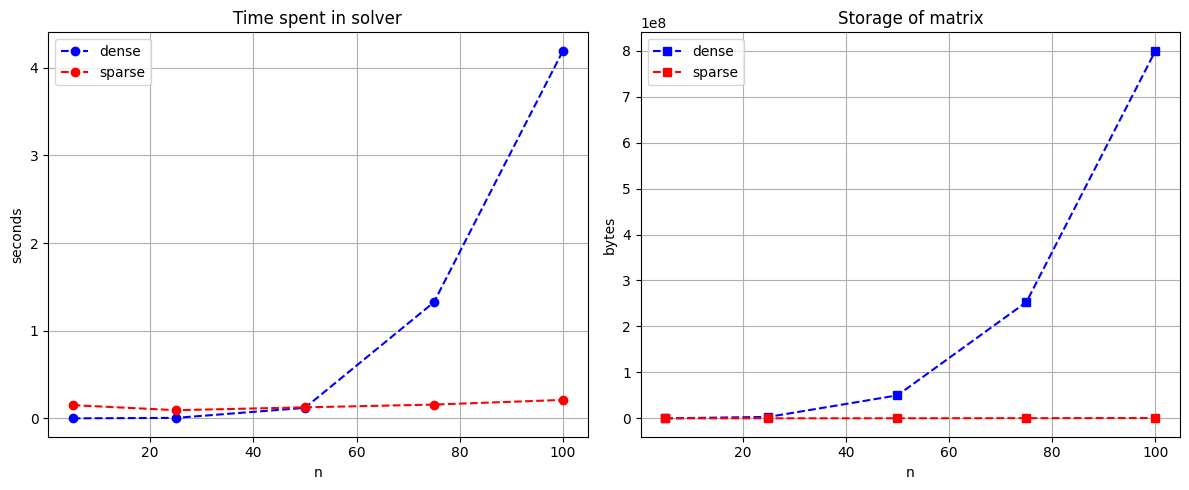

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# time plot
ax1.plot(dimensions, timeDense, marker='o', linestyle='--', color='b', label='dense')
ax1.plot(dimensions, timeSparse, marker='o', linestyle='--', color='r', label='sparse')
ax1.set_xlabel('n')
ax1.set_ylabel('seconds')
ax1.set_title('Time spent in solver')
ax1.legend()
ax1.grid(True)

# storage plot
ax2.plot(dimensions, storageDense, marker='s', linestyle='--', color='b', label='dense')
ax2.plot(dimensions, storageSparse, marker='s', linestyle='--', color='r', label='sparse')
ax2.set_xlabel('n')
ax2.set_ylabel('bytes')
ax2.set_title('Storage of matrix')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
